<a href="https://colab.research.google.com/github/zaid-khan/hello-world/blob/master/PrintLDA_MachineLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
pip install paramiko

    100% |████████████████████████████████| 194kB 10.3MB/s 
    100% |████████████████████████████████| 2.3MB 12.1MB/s 
    100% |████████████████████████████████| 61kB 26.3MB/s 
    100% |████████████████████████████████| 768kB 28.8MB/s 
    100% |████████████████████████████████| 102kB 33.5MB/s 


In [0]:
import sys
# !{sys.executable} -m spacy download en
import re, numpy as np, pandas as pd
from pprint import pprint
import nltk
nltk.download('stopwords')
# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
stop_words[:100]

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once']

In [0]:
# Import Dataset
df = pd.read_json('https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json')
df = df.loc[df.target_names.isin(['soc.religion.christian', 'rec.sport.hockey', 'talk.politics.mideast', 'rec.motorcycles']) , :]
print(df.shape)  #> (2361, 3)
df.head()

(2361, 3)


,content,target,target_names
10,From: irwin@cmptrc.lonestar.org (Irwin Arnstei...,8,rec.motorcycles
10007,From: jet@netcom.Netcom.COM (J. Eric Townsend)...,8,rec.motorcycles
10008,From: gld@cunixb.cc.columbia.edu (Gary L Dare)...,10,rec.sport.hockey
10017,From: nstramer@supergas.dazixco.ingr.com (Naft...,17,talk.politics.mideast
10019,From: mussack@austin.ibm.com (Christopher Muss...,15,soc.religion.christian


In [0]:
data = df.content.values.tolist()
data[:5]

['From: irwin@cmptrc.lonestar.org (Irwin Arnstein)\nSubject: Re: Recommendation on Duc\nSummary: What\'s it worth?\nDistribution: usa\nExpires: Sat, 1 May 1993 05:00:00 GMT\nOrganization: CompuTrac Inc., Richardson TX\nKeywords: Ducati, GTS, How much? \nLines: 13\n\nI have a line on a Ducati 900GTS 1978 model with 17k on the clock.  Runs\nvery well, paint is the bronze/brown/orange faded out, leaks a bit of oil\nand pops out of 1st with hard accel.  The shop will fix trans and oil \nleak.  They sold the bike to the 1 and only owner.  They want $3495, and\nI am thinking more like $3K.  Any opinions out there?  Please email me.\nThanks.  It would be a nice stable mate to the Beemer.  Then I\'ll get\na jap bike and call myself Axis Motors!\n\n-- \n-----------------------------------------------------------------------\n"Tuba" (Irwin)      "I honk therefore I am"     CompuTrac-Richardson,Tx\nirwin@cmptrc.lonestar.org    DoD #0826          (R75/6)\n------------------------------------------

In [0]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert to list
data = df.content.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1])
# [['from', 'irwin', 'arnstein', 'subject', 're', 'recommendation', 'on', 'duc', 'summary', 'whats', 'it', 'worth', 'distribution', 'usa', 'expires', 'sat', 'may', 'gmt', ...trucated...]]

[['from', 'irwin', 'arnstein', 'subject', 're', 'recommendation', 'on', 'duc', 'summary', 'whats', 'it', 'worth', 'distribution', 'usa', 'expires', 'sat', 'may', 'gmt', 'organization', 'computrac', 'inc', 'richardson', 'tx', 'keywords', 'ducati', 'gts', 'how', 'much', 'lines', 'have', 'line', 'on', 'ducati', 'gts', 'model', 'with', 'on', 'the', 'clock', 'runs', 'very', 'well', 'paint', 'is', 'the', 'bronze', 'brown', 'orange', 'faded', 'out', 'leaks', 'bit', 'of', 'oil', 'and', 'pops', 'out', 'of', 'st', 'with', 'hard', 'accel', 'the', 'shop', 'will', 'fix', 'trans', 'and', 'oil', 'leak', 'they', 'sold', 'the', 'bike', 'to', 'the', 'and', 'only', 'owner', 'they', 'want', 'and', 'am', 'thinking', 'more', 'like', 'any', 'opinions', 'out', 'there', 'please', 'email', 'me', 'thanks', 'it', 'would', 'be', 'nice', 'stable', 'mate', 'to', 'the', 'beemer', 'then', 'ill', 'get', 'jap', 'bike', 'and', 'call', 'myself', 'axis', 'motors', 'tuba', 'irwin', 'honk', 'therefore', 'am', 'computrac', 'r

In [0]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# !python3 -m spacy download en  # run in terminal once
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)  # processed Text Data!

/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [0]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
#lda_model = gensim.models.LdaMulticore(corpus=corpus,
#                                            id2word=id2word,
#                                            num_topics=20, 
#                                            random_state=100,
#                                            update_every=1,
#                                            chunksize=10,
#                                            passes=10,
#                                            alpha='symmetric',
#                                            iterations=100,
#                                            per_word_topics=True)

lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True, workers=5)

pprint(lda_model.print_topics())

[(0,
  '0.015*"game" + 0.015*"team" + 0.008*"play" + 0.008*"player" + '
  '0.007*"hockey" + 0.006*"organization" + 0.006*"win" + 0.006*"year" + '
  '0.006*"season" + 0.005*"university"'),
 (1,
  '0.013*"organization" + 0.011*"write" + 0.011*"bike" + 0.010*"article" + '
  '0.005*"dod" + 0.004*"university" + 0.004*"motorcycle" + 0.004*"time" + '
  '0.004*"new" + 0.004*"ride"'),
 (2,
  '0.010*"people" + 0.008*"armenian" + 0.006*"god" + 0.006*"write" + '
  '0.005*"christian" + 0.004*"time" + 0.004*"believe" + 0.004*"organization" + '
  '0.004*"tell" + 0.004*"article"'),
 (3,
  '0.011*"israel" + 0.010*"israeli" + 0.008*"arab" + 0.008*"write" + '
  '0.007*"article" + 0.006*"organization" + 0.005*"jew" + 0.005*"state" + '
  '0.005*"palestinian" + 0.004*"people"')]


In [0]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.7094,"organization, write, bike, article, dod, unive...","[irwin, arnstein, recommendation, duc, summary..."
1,1,1.0,0.8396,"organization, write, bike, article, dod, unive...","[eric, townsend, insurance, lotsa_point, reply..."
2,2,1.0,0.5431,"organization, write, bike, article, dod, unive...","[gary_dare, abc_coverage, reply, gary_dare, or..."
3,3,3.0,0.7394,"israel, israeli, arab, write, article, organiz...","[naftaly_stramer, peace_talk, reply, organizat..."
4,4,2.0,0.9961,"people, armenian, god, write, christian, time,...","[question, authority, trendy, liberal, feminis..."
5,5,2.0,0.8573,"people, armenian, god, write, christian, time,...","[harrass, work, prayer, reply, organization, u..."
6,6,1.0,0.9198,"organization, write, bike, article, dod, unive...","[andrew_infante, ok, little_hasty, organizatio..."
7,7,2.0,0.7790,"people, armenian, god, write, christian, time,...","[james_sledd, afterlife, organization, social,..."
8,8,1.0,0.5515,"organization, write, bike, article, dod, unive...","[canadien, stanley_cup, organization, canada, ..."
9,9,0.0,0.9759,"game, team, play, player, hockey, organization...","[steve_gallichio, possible, canadian, wc, team..."


In [0]:
df_dominant_topic.describe()

,Document_No,Dominant_Topic,Topic_Perc_Contrib
count,2361.000000,2361.000000,2361.000000
mean,1180.000000,1.454892,0.849186
std,681.706315,0.953461,0.168979
min,0.000000,0.000000,0.308900
25%,590.000000,1.000000,0.724300
50%,1180.000000,1.000000,0.931200
75%,1770.000000,2.000000,0.988700
max,2360.000000,3.000000,0.999800


In [0]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9994,"game, team, play, player, hockey, organization, win, year, season, university","[rocket, nhl, final, point, standing, organization, university, new_brunswick, sport_hockey, ind..."
1,1.0,0.9977,"organization, write, bike, article, dod, university, motorcycle, time, new, ride","[ryan_cousineau, spagthorpe_vik, reply, organization, dan_sorenson, ryan_cousineau, write, rid, ..."
2,2.0,0.9998,"people, armenian, god, write, christian, time, believe, organization, tell, article","[david_davidian, account, anti, armenian, current_event, organization, center, regional_studie, ..."
3,3.0,0.9988,"israel, israeli, arab, write, article, organization, jew, state, palestinian, people","[yigal_aren, ten_question, organization, usc, information, science, institute, grl, isi, reply, ..."


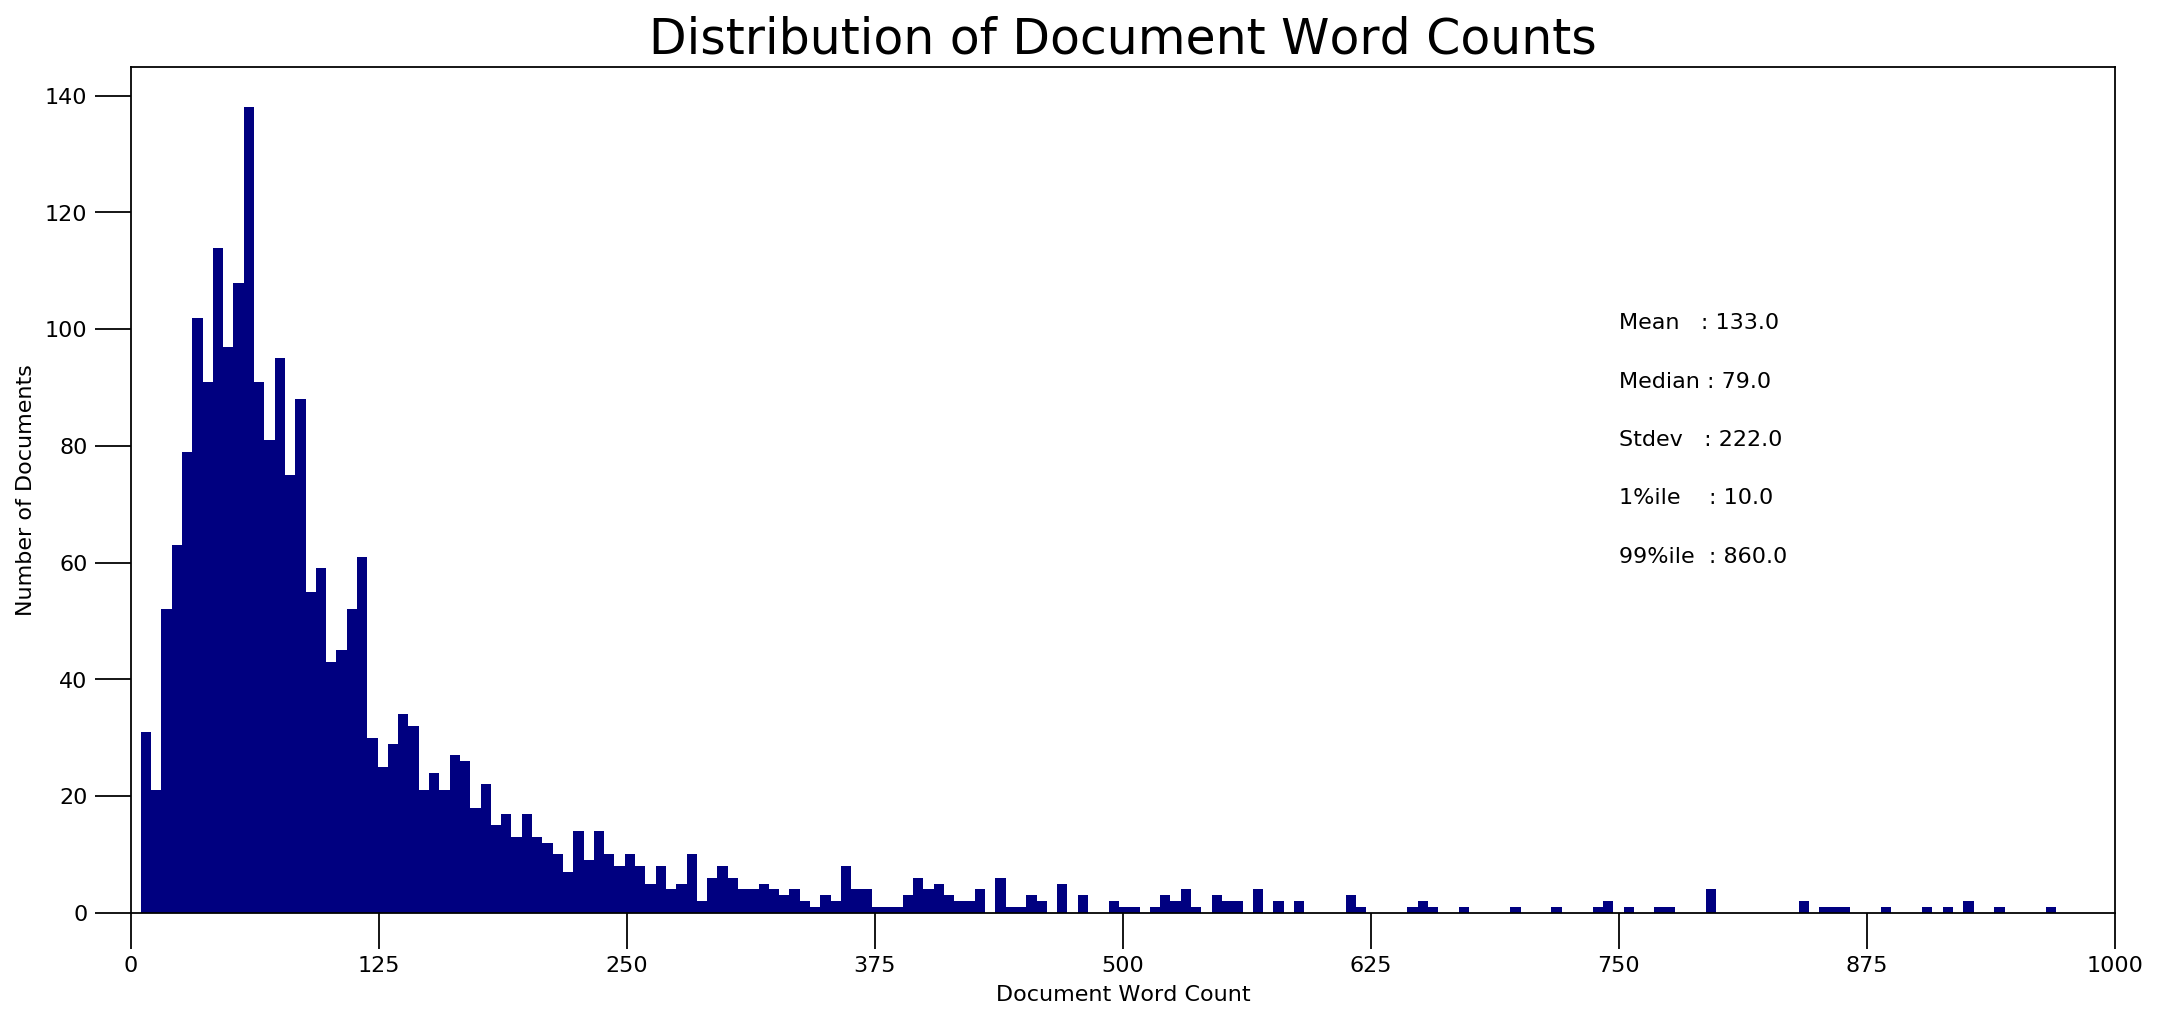

In [0]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

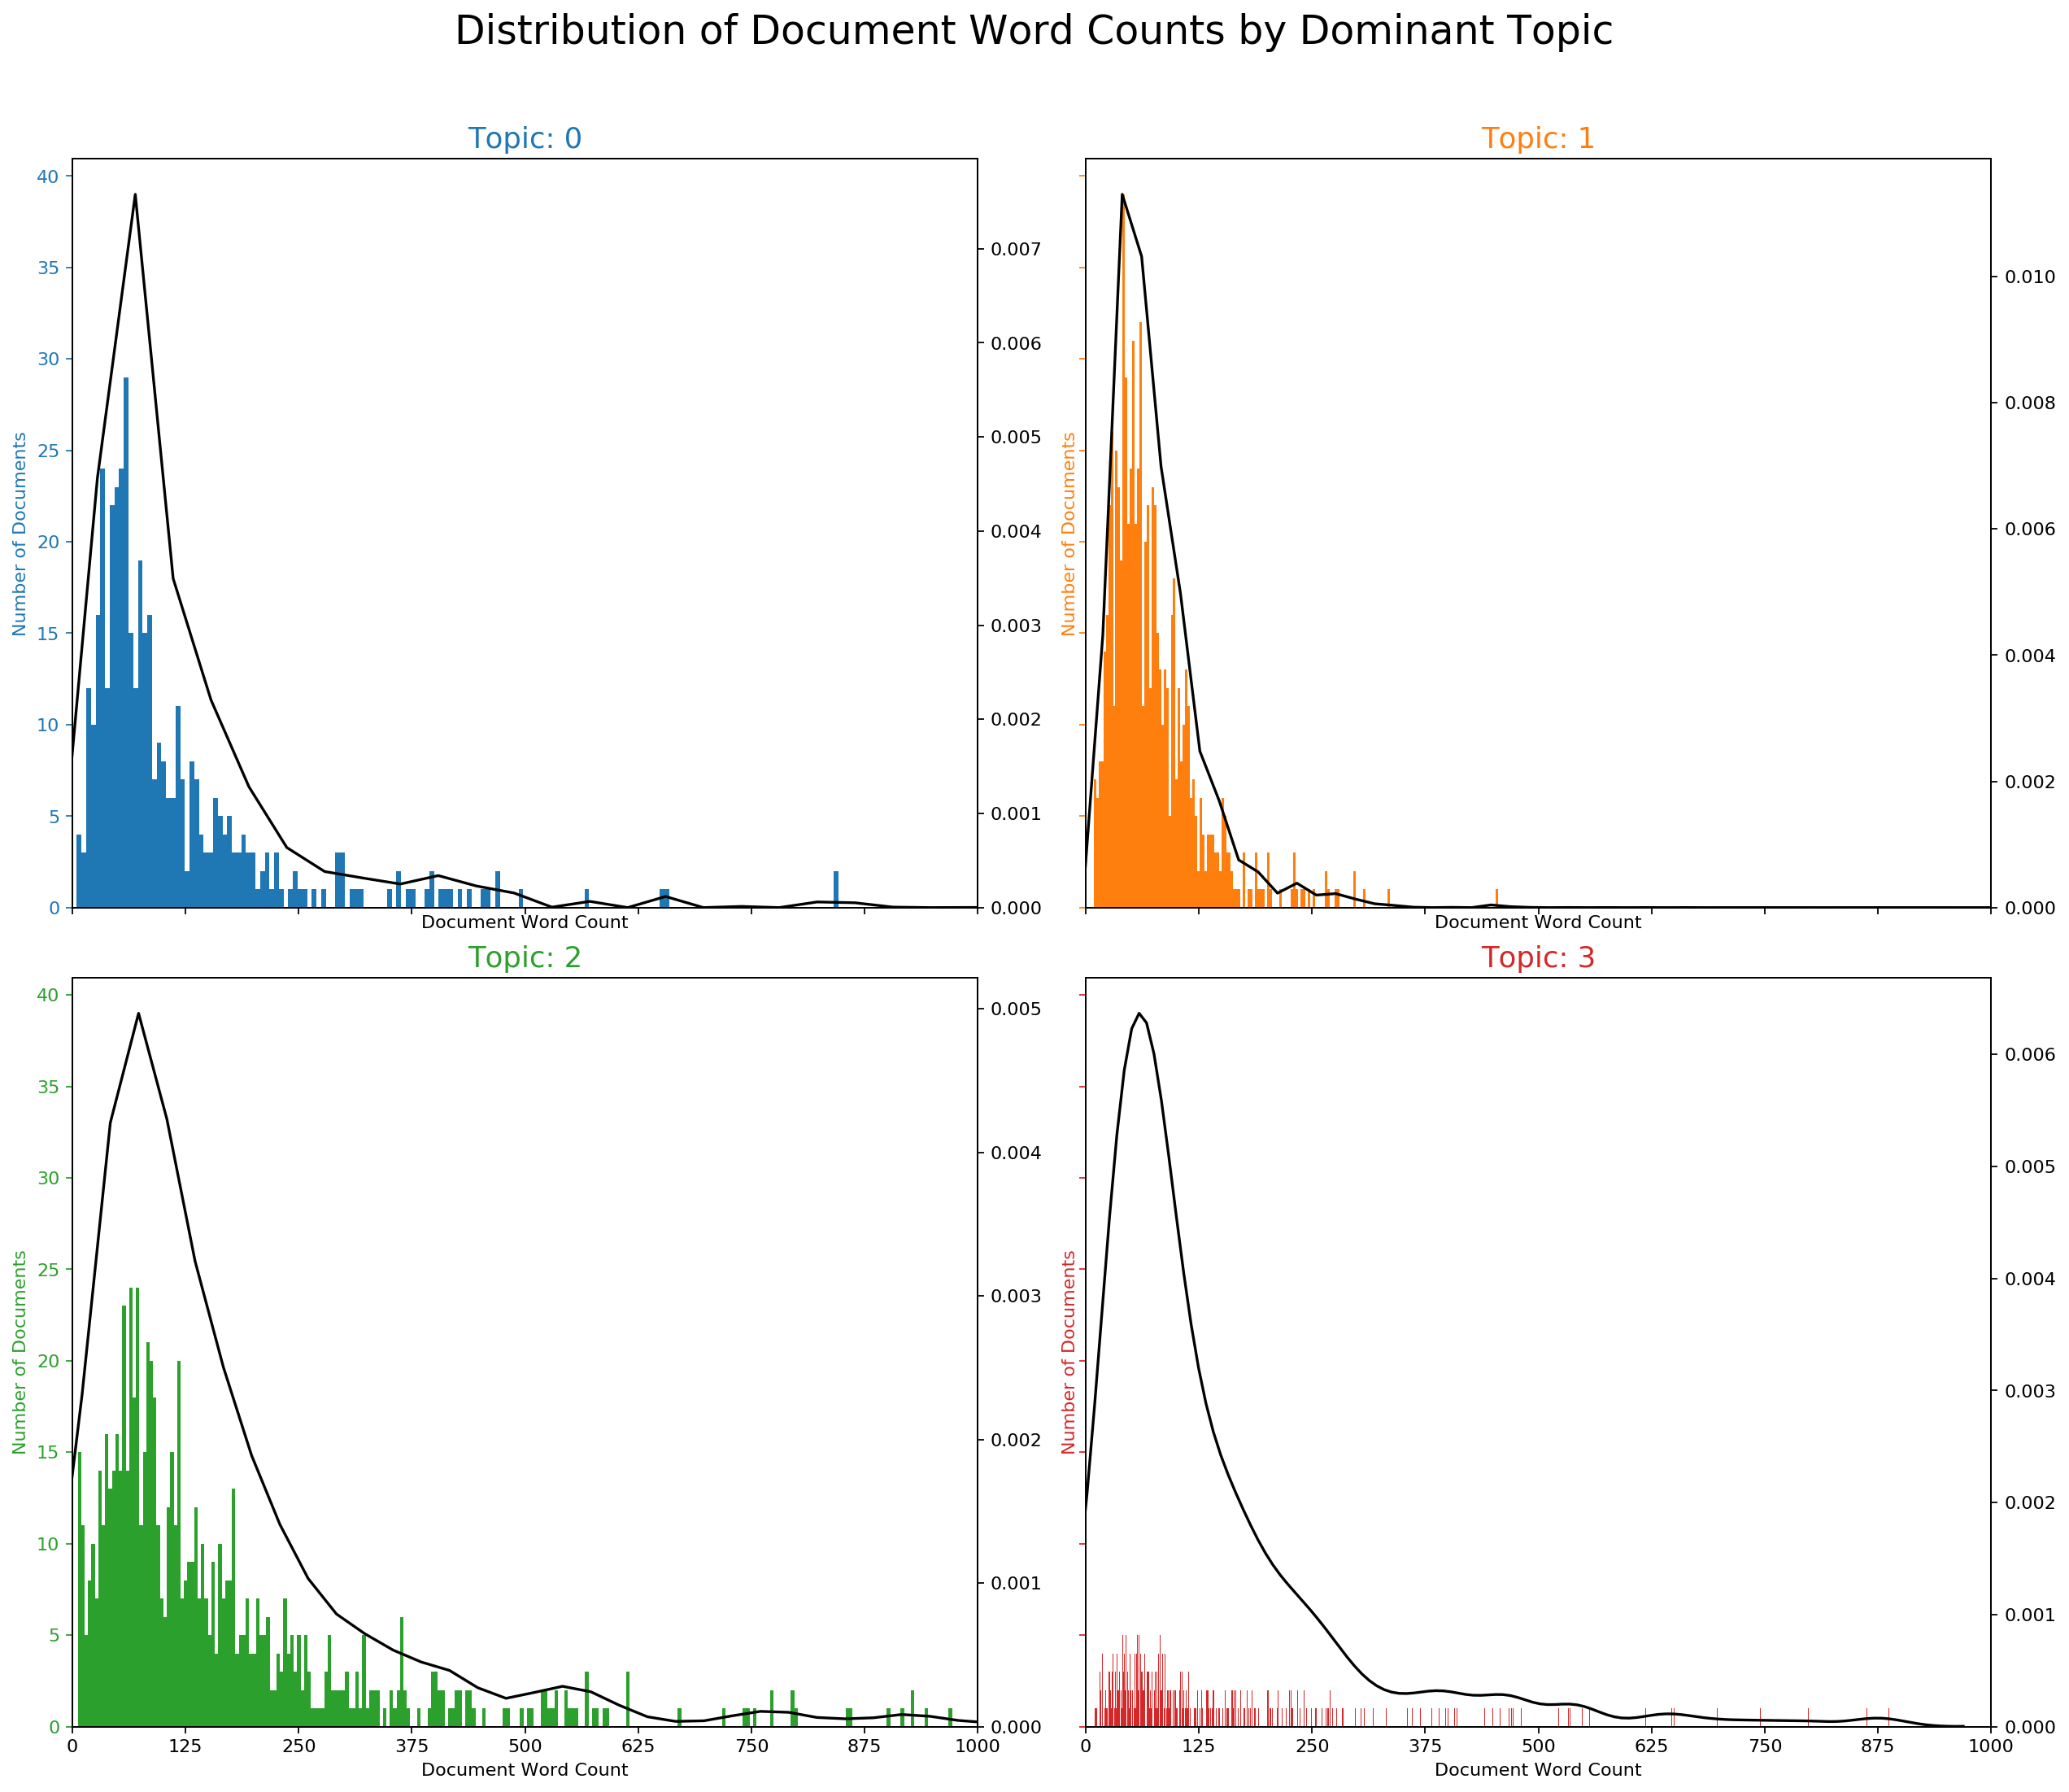

In [0]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 1000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

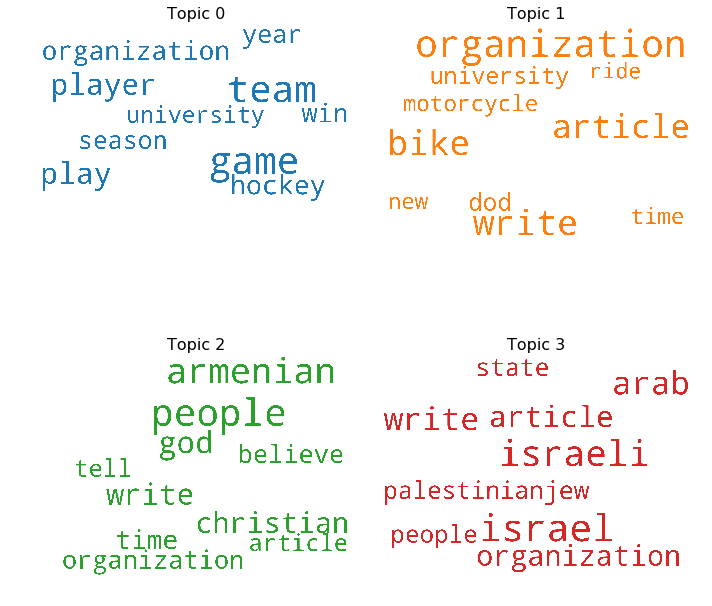

In [0]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

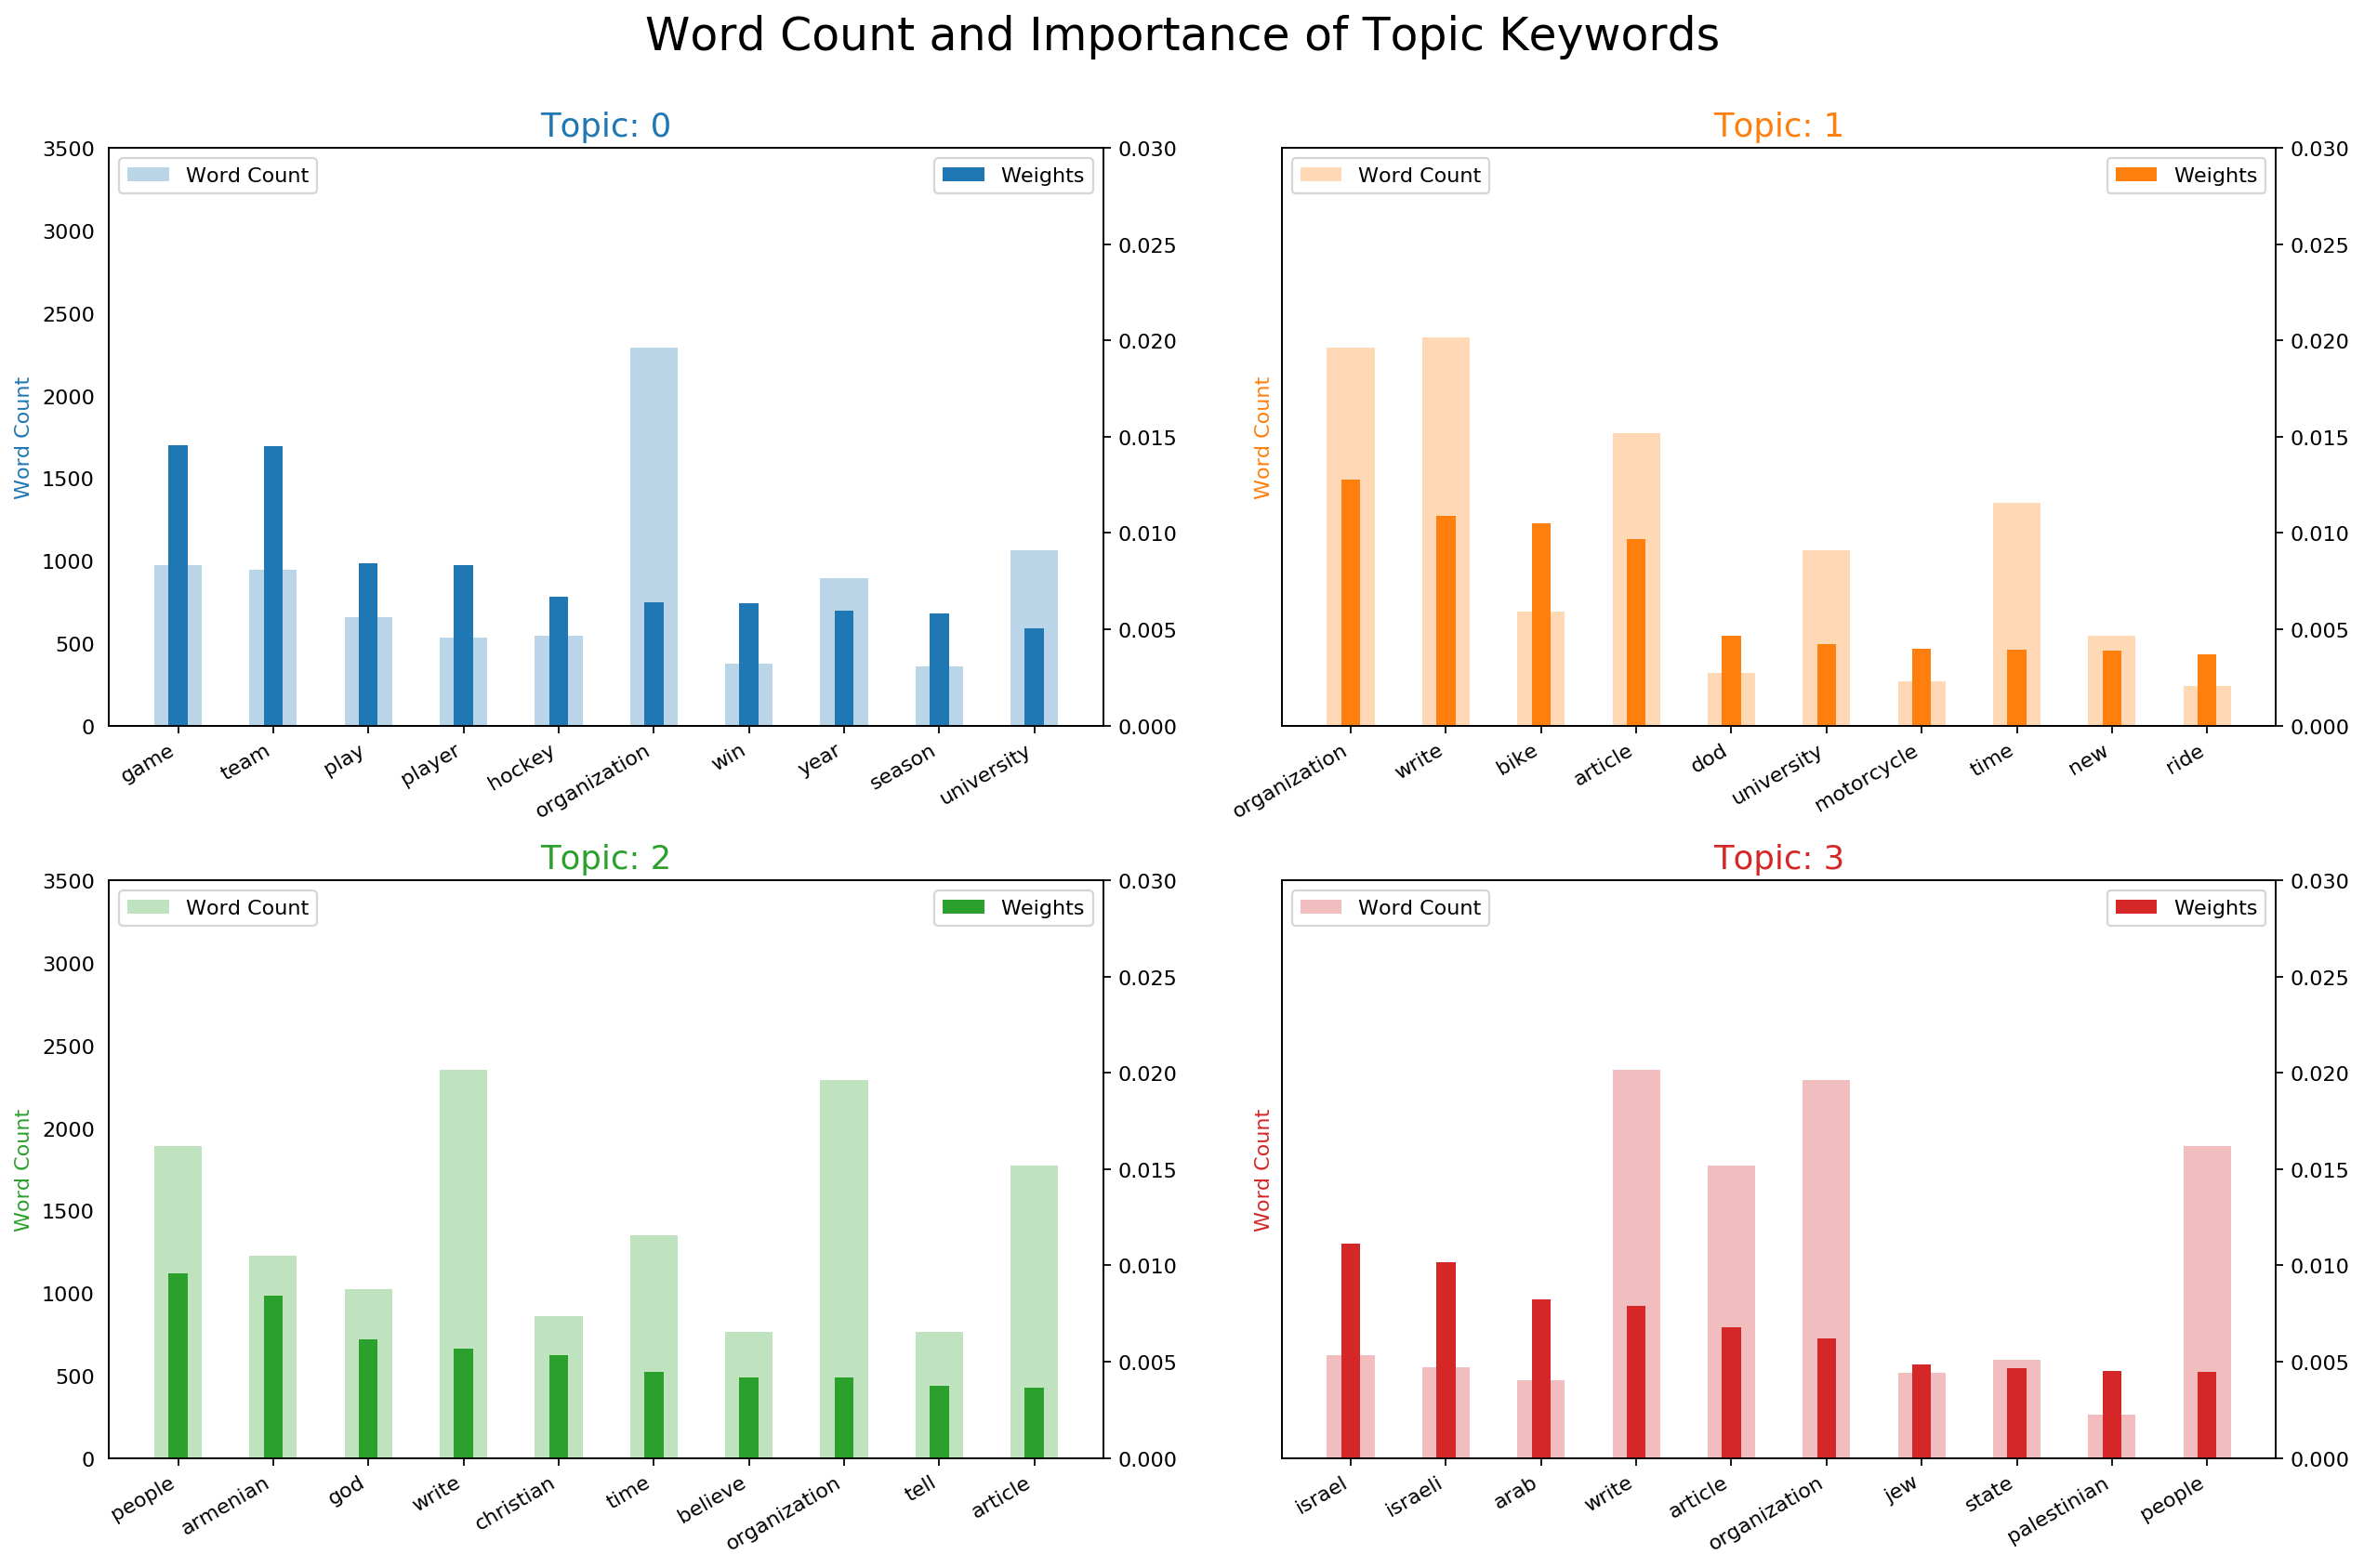

In [0]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

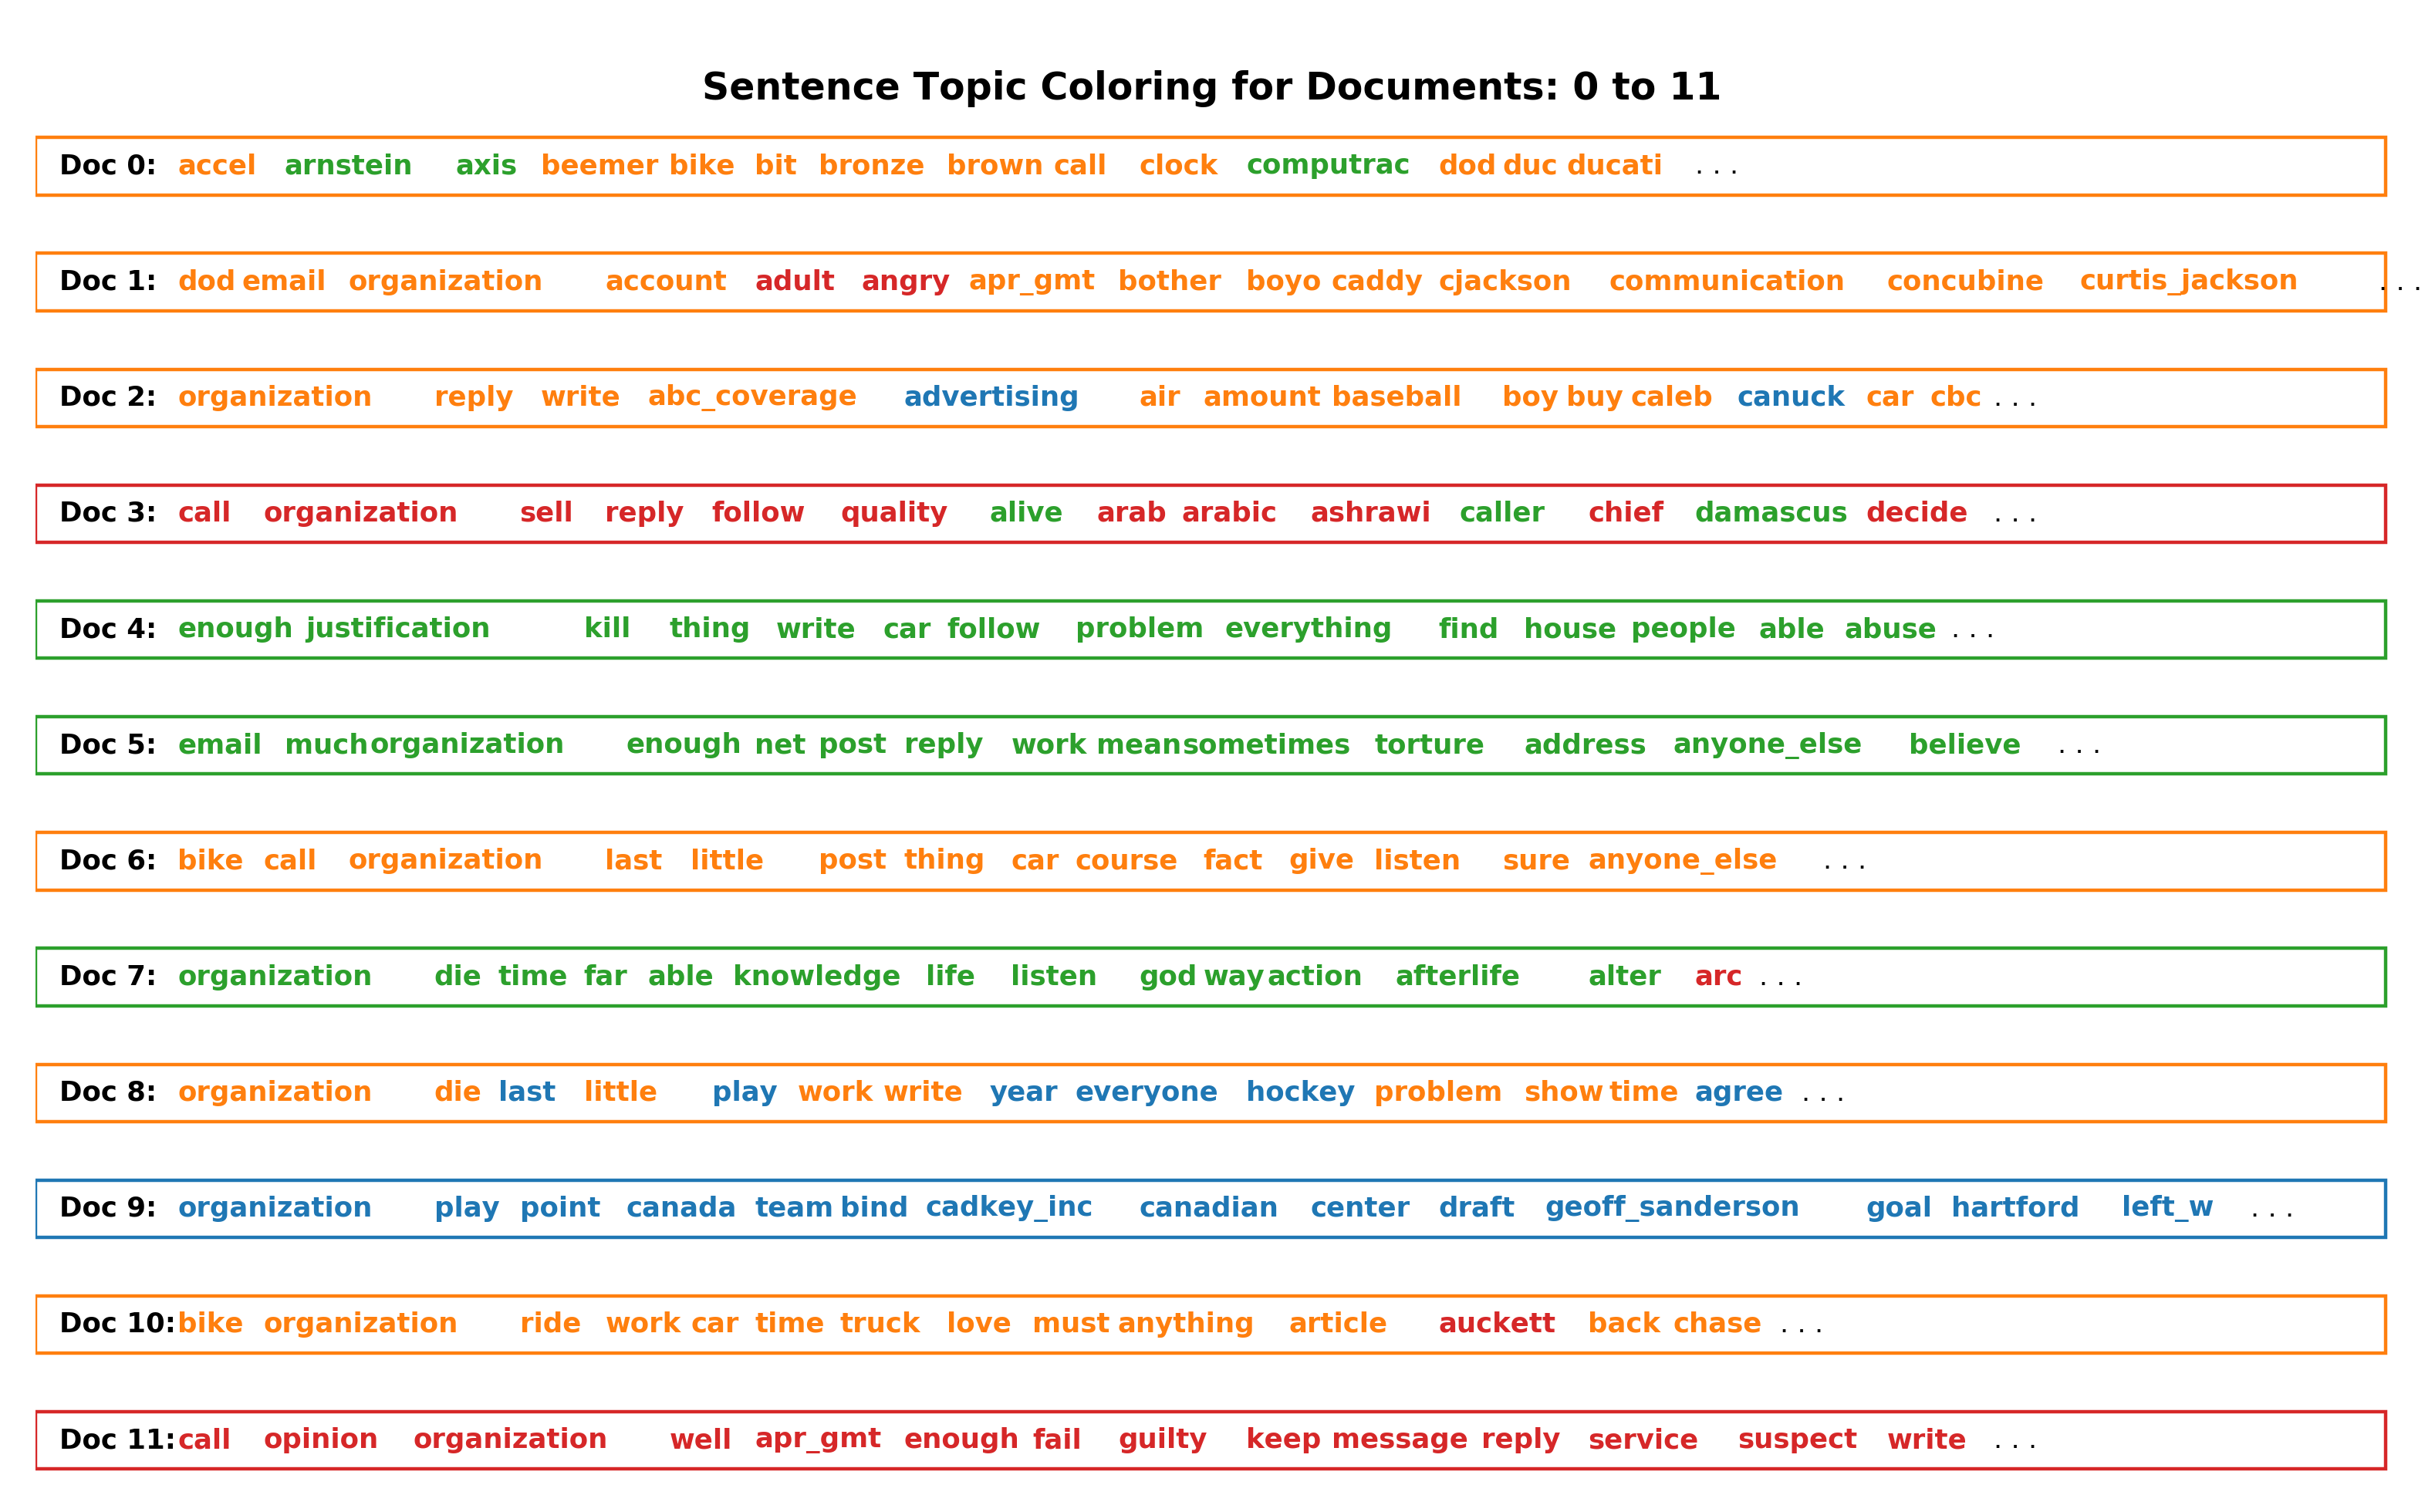

In [0]:
# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda_model, corpus=corpus, start = 0, end = 13):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart()

In [0]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

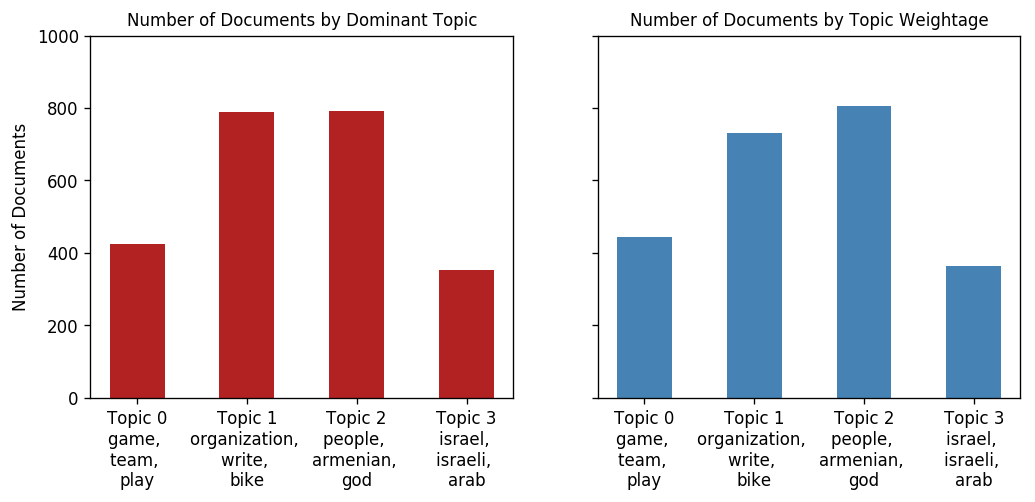

In [0]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 1000)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()

In [0]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2357 samples in 0.001s...
[t-SNE] Computed neighbors for 2357 samples in 0.028s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2357
[t-SNE] Computed conditional probabilities for sample 2000 / 2357
[t-SNE] Computed conditional probabilities for sample 2357 / 2357
[t-SNE] Mean sigma: 0.000322
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.973392
[t-SNE] KL divergence after 1000 iterations: 0.289144


Loading BokehJS ...

In [0]:
pip install pyLDAvis

    100% |████████████████████████████████| 1.6MB 17.7MB/s 
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
Successfully built pyLDAvis


In [0]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

/usr/local/lib/python3.6/dist-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.124454  0.023228       1        1  47.317654
1     -0.046814 -0.158150       2        1  18.828470
0     -0.202716  0.082888       3        1  17.634548
3      0.125077  0.052034       4        1  16.219334, topic_info=     Category         Freq          Term        Total  loglift  logprob
1181  Default   888.000000          game   888.000000  30.0000  30.0000
526   Default   882.000000          team   882.000000  29.0000  29.0000
4     Default   620.000000          bike   620.000000  28.0000  28.0000
712   Default   574.000000        israel   574.000000  27.0000  27.0000
2312  Default   519.000000       israeli   519.000000  26.0000  26.0000
1483  Default  1253.000000      armenian  1253.000000  25.0000  25.0000
194   Default   426.000000          arab   426.000000  24.0000  24.0000
2521  Default   486.000000        player   486.000000  23.0000  23.0000
98    Default   575.000000          play   575.000000  22.0000  22.0000
529   Default   360.000000           win   360.000000  21.0000  21.0000
34    Default  2040.000000  organization  2040.000000  20.0000  20.0000
157   Default   529.000000        hockey   529.000000  19.0000  19.0000
394   Default   925.000000           god   925.000000  18.0000  18.0000
549   Default   346.000000        season   346.000000  17.0000  17.0000
554   Default  1638.000000       article  1638.000000  16.0000  16.0000
965   Default   801.000000     christian   801.000000  15.0000  15.0000
2315  Default   428.000000           jew   428.000000  14.0000  14.0000
11    Default   276.000000           dod   276.000000  13.0000  13.0000
127   Default  2122.000000         write  2122.000000  12.0000  12.0000
539   Default   303.000000          goal   303.000000  11.0000  11.0000
228   Default   231.000000   palestinian   231.000000  10.0000  10.0000
1408  Default   333.000000           nhl   333.000000   9.0000   9.0000
1028  Default   240.000000    motorcycle   240.000000   8.0000   8.0000
543   Default   238.000000       playoff   238.000000   7.0000   7.0000
107   Default   226.000000          ride   226.000000   6.0000   6.0000
548   Default   206.000000         score   206.000000   5.0000   5.0000
2396  Default   335.000000        jewish   335.000000   4.0000   4.0000
1486  Default   322.000000        attack   322.000000   3.0000   3.0000
1650  Default   413.000000       turkish   413.000000   2.0000   2.0000
128   Default   845.000000          year   845.000000   1.0000   1.0000
...       ...          ...           ...          ...      ...      ...
1510   Topic4   130.762405      civilian   165.584396   1.5829  -5.9624
2620   Topic4    77.779335        occupy    96.122627   1.6072  -6.4820
3052   Topic4    94.817268        border   123.598427   1.5539  -6.2839
2474   Topic4    40.504868     tim_clock    45.128208   1.7109  -7.1344
2315   Topic4   246.724762           jew   428.300812   1.2674  -5.3276
3799   Topic4    65.470688     jerusalem    83.521774   1.5755  -6.6542
1239   Topic4   143.452438         peace   230.828217   1.3433  -5.8698
1486   Topic4   175.503250        attack   322.482849   1.2106  -5.6682
2611   Topic4   127.892067          land   219.784286   1.2775  -5.9846
536    Topic4   171.906799        center   354.072571   1.0964  -5.6889
243    Topic4   237.343185         state   568.765747   0.9450  -5.3663
2396   Topic4   162.470139        jewish   335.786011   1.0930  -5.7453
3389   Topic4   127.843704       soldier   252.111359   1.1399  -5.9850
89     Topic4   190.565918          kill   538.317200   0.7805  -5.5858
2646   Topic4    70.464119     terrorist   101.720200   1.4518  -6.5807
127    Topic4   401.966278         write  2122.189453   0.1551  -4.8395
554    Topic4   346.082733       article  1638.761353   0.2639  -4.9892
620    Topic4   130.307037          case   314.129150   0.9391  -5.9659
34     Topic4   315.429230  organ